In [59]:
# Generic imports
import functools
import warnings

#Numerical tools
import numpy as np

#Math and linear algebra stuff
import scipy.stats as scs

# Deep learning stuff
import tensorflow as tf
from tensorflow import keras

# Probabilistic stuff
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16.0, 9.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

#tf.enable_v2_behavior()
warnings.filterwarnings('ignore')

# Normalizing flows for Generative model in Deep Learning

## Introduction

This notebook is somehow a follow up the InformationTheoryOptimization notebook. Some basic concepts exposed there will be used here. But we will give a short reminder.

## Definitions

### Bayes theorem

Although Bayesian statistics is not really a novel approach, the recent rise of probabilistic programming libraries, availability of a lot of data, and powerful computer to run markov chains, made the tedious task of running bayesian inference algorithms a lot easier.

Let's recall some simple elements about the Bayes theorem that we have been in other notebooks:

For two given random variables, $X$ and $\theta$, we can write :
\begin{equation}
    P(\theta|x) = \frac{P(x|\theta)P(\theta)}{P(x)}
\end{equation}


We could use a slightly more formal version, that includes a model $\mathcal{M}$ that we believe is the underlying model for the random variable $x$, parametrized by $\theta$

\begin{equation}
    P(\theta|x,\mathcal{M}) = \frac{P(x|\theta, \mathcal{M})P(\theta|\mathcal{M})}{P(x|\mathcal{M})}
\end{equation}

* Usually, $\theta$ is the random variable that we would like to caracterize. It usually consist in a set of parameters for a given statistical model (mean and variance for a normal distribution for instance).

* On the contrary $x$, called the evidence, is usually derived from a known dataset, or from sampling a real life process. We will see shortly how we can define an empirical distribution from a set of samples. 

* We call $P(x|\theta)$ the likelihood of $x$, given the model distribution  $\theta$. This is the likelihood (or its logarithm) we tried to maximize with various instances of expectation maximization algorithm in the InformationTheory notebook by finding the optimal model parameters $\theta$.
Maximum likelihood had some success in the past for some instance of problems where likelihood or its logarithm were concave and differentiable, and a gradient based methods allowed to find a global maximum.

* We call $P(\theta|x)$ the posterior distribution of $\theta$, given a known (usually empirical distribution of data) $x$. As opposite to the prior, it gives an idea of the probability of the model AFTER some data ($x$) has been seen.

* We call $P(\theta)$ the a-priori distribution for the variable $\theta$. This one can be derived if we have a-priori knowledge on the model parameters $\theta$, it may consist in apriori knowledge of some surrogate parameters that we integrate as a marginal distribution and scale. A prior usually allows us to compute the probability of a given set of parameters $\theta \in \mathbb{R}^n$ that feed the model $\mathcal{M}$.

A priori usually writes:
  \begin{align*}
    y &\rightarrow P(\theta=y) \\
    \mathbb{R}^n &\mapsto [0,1]
  \end{align*}
  
A concrete example is for instance, the use of the framework of random markov field (or Gibbs random field) in a n-dimensional space like an image, were we can consider the pixels as a set of vertices of a graph, and only neighbouring pixels are connected by edges. The probability of a given graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ is given by $P(\mathcal{G}) = \alpha e^{-\beta U(\mathcal{G})}$ where $\alpha$ and $\beta$ are normalization factor, and $U(\mathcal{G}) = \sum_{c\in C} V_c(\mathcal(G))$ is a sum of clique potentials $V_c(\mathcal(G))$ over all possible cliques $C$. A very common instance of Gibbs measure is the gaussian-like distribution where, we have, for each neighbouring pair of pixel $p_1-p_2$ (a clique): $V_{p_1-p_2}(\mathcal{G}) = (\mathcal{G}_{p_1}-\mathcal{G}_{p_2})^2$
When one has no apriori on $\theta$, then the highest entropy hypothesis is implicitly used. More pragmatically, we write $P(\theta=y) \sim Uniform(\mathrm{supp} \theta)$ where $\mathrm{supp} \theta$ is the support of $\theta$
Notice that, given a discrete process, as long as we received new data, the prior distribution can be taken just as being the previous step posterior.

* Usually $P(x)$ is the empirical distribution that correspond to a given set of outcomes (actual data). It represents the probability of the given outcome of the experiment regardless of the value of the underlying model $\theta$. We can see $P(x)$ as a marginalization of $\theta$ in the joint distribution $P(x,\theta)=P(x|\theta)P(\theta)$ i.e. $P(x) = \int_{\theta} P(x,\theta)$ such that it acts as a constant used to normalize likelihood  / prior product to make sure the result posterior is a distribution.

### Bayesian inference and the sampling task

As briefly seen in the InformationTheory notebook, in the general case, to compute the posterior over the whole support of $\theta$ is an extremely complex problem, especially if $\theta$ is a vector from a high dimension space, and the actual distribution of the posterior is very complex (not smooth, many local density maxima, etc...). MCMC types of methods often comes into play here, where one computes $P(\theta=y_0|x)$ for a given $y_0$, then jumps to another point $y_1$ in space $\theta$ , with a given probably, dependant on $P(\theta=y|x)$.
Little by little one can get a discrete approximation of the posterior, but it can be very slow.

For instance, as part of tensorflow probability you get the following methods:

In [2]:
print(tfp.mcmc.MetropolisHastings.__doc__)
print("=================================")
print(tfp.mcmc.RandomWalkMetropolis.__doc__)
print("=================================")
print(tfp.mcmc.MetropolisAdjustedLangevinAlgorithm.__doc__)
print("=================================")
print(tfp.mcmc.NoUTurnSampler.__doc__)
print("=================================")
print(tfp.mcmc.ReplicaExchangeMC.__doc__)
print("=================================")
print(tfp.mcmc.HamiltonianMonteCarlo.__doc__)

Runs one step of the Metropolis-Hastings algorithm.

  The [Metropolis-Hastings algorithm](
  https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) is a
  Markov chain Monte Carlo (MCMC) technique which uses a proposal distribution
  to eventually sample from a target distribution.

  Note: `inner_kernel.one_step` must return `kernel_results` as a
  `collections.namedtuple` which must:

  - have a `target_log_prob` field,
  - optionally have a `log_acceptance_correction` field, and,
  - have only fields which are `Tensor`-valued.

  The Metropolis-Hastings log acceptance-probability is computed as:

  ```python
  log_accept_ratio = (current_kernel_results.target_log_prob
                      - previous_kernel_results.target_log_prob
                      + current_kernel_results.log_acceptance_correction)
  ```

  If `current_kernel_results.log_acceptance_correction` does not exist, it is
  presumed `0.` (i.e., that the proposal distribution is symmetric).

  The most c

### Probabilistic inference for latent variable models parametrized by $\theta$

I found this [blog post](https://mbernste.github.io/posts/elbo/) introduction very well written, as it sets bayesian framework in the context of a model where parameters $\theta$ are distincts from latent states $z$. This type of models is very common, and the formulation of posterior changes quite a lot from what we have seen in the InformationTheory notebook, as the model parameters are not the one we want a distribution for anymore.

Here is an exerpt of the above link:

Before digging in, let’s review the probabilistic inference task for a latent variable model. In a latent variable model, we posit that our observed data $x$ is a realization from some random variable $X$. Moreoever, we posit the existence of another random variable $Z$ where $X$ and $Z$ are distributed according to a joint distribution $p(X,Z;\theta)$ where $\theta$ parameterizes the distribution.Unfortunately, our data is only a realization of $X$, not $Z$, and therefore $Z$ remains unobserved (i.e. latent).

There are two predominant tasks that we may be interested in accomplishing:

* Given some prior distribution over $Z$, $P(Z)$, compute the posterior distribution $p(Z∣X;\theta)$
* Compute the maximum likelihood estimate of $\theta$:
\begin{align*}
  \underset{\theta}{argmax} \quad l(\theta)
\end{align*}
where $l(\theta)$ is the log-likelihood function:
\begin{align*}
  l(\theta) = log(p(x;\theta)) = log \left( \int p(x,z;\theta) dz \right)
\end{align*}

Variational inference is used for Task 1 and expectation-maximization is used for Task 2. Both of these algorithms rely on the ELBO, a concept we will explain hereafter.

### ELBO for latent variable models

To understand the evidence lower bound, we must first understand what we mean by “evidence”. The evidence, quite a simply, is just a name given to the likelihood function evaluated at a fixed $\theta$:

\begin{align*}
  \text{evidence} \; = \; log(p(x;\theta))
\end{align*}

Why is this quantity called the “evidence” ? Intuitively, if we have chosen the right model $p$ and $\theta$, then we would expect that the marginal probability of our observed data $x$, would be high. Thus, a higher value of $log(p(x;\theta))$ indicates, in some sense, that we may be on the right track with the model $p$ and parameters $\theta$ that we have chosen. That is, this quantity is “evidence” that we have chosen the right model for the data.

If we happen to also know (or posit) that $Z$ follows some distribution denoted by $q$ (and that $p(x,z;\theta) = p(x|z;\theta)q(z)$), then the evidence lower bound is, well, just a lower bound on the evidence that makes use of the known (or posited) $q$. Specifically,

\begin{align*}
  log(p(x;\theta)) \geq \mathbb{E}_q \left[ \frac{p(x,z;\theta)}{q(z)}  \right]
\end{align*}

where the ELBO is simply the right-hand side of the above equation. We will show how this 

## Kullback Leibler divergence

The Kullback Leibler divergence, also called the relative entropy or discrimination information, can be computed between two distributions, say $x$ and $y$ and writes $ D_{KL}(x\|y) $.
This metric represents the expectation of the difference of the number of bits needed to encode a symbol from the distribution x, weither the encoding is optimal for the distribution x or y.

The general case reads:

\begin{align}
    D_{KL}(x\|y) &= \mathbb{E}_x \left[ log \left( \frac{x}{y} \right) \right]
\end{align}

In the discrete case it reads:

\begin{align}
    D_{KL}(x\|y) &= \sum_{i\in I} p(x_i) log(p(x_i)) -\sum_{i\in I} p(x_i) log(p(y_i)) \\
                 &= -H(x) + H_y(x)
\end{align}
or equivalently
$$
    D_{KL}(x\|y) = \sum_{i\in I} p(x_i) log\left(\frac{p(x_i)}{p(y_i)}\right)
$$


### Reminder on KL Divergence and maximum likelihood
This paragraph was inspired by [this article](http://www.hongliangjie.com/2012/07/12/maximum-likelihood-as-minimize-kl-divergence/)
by Liangjie Hong

#### Definitions
Let's consider $P(x_i|\theta)$ a distribution used to generate (or sample) $N$ points $x_i, i=0,\dots,N-1$

We can define a general distribution model as:
$$
    P_\theta(x) = P(x|\theta) = P(x;\theta)
$$
And, to handle data from real world, we will define the following empirical distribution (also called probability mass function):
$$
    P_D(x) = \sum_{i=0}^{N-1} \frac{1}{N} \delta(x-x_i)
$$

#### KL Divergence between model and data
We can now express the Kullback Leibler divergence between the model distribution and the empirical one:

\begin{align}
    D_{KL} \left( P_D(x)||P_\theta(x) \right) &= \int P_D(x) log(P_D(x)) dx -\int P_D(x) log(P_\theta(x)) dx \\
    &= H(P_D(x)) - \int P_D(x) log(P_\theta(x)) dx
\end{align}

As $H(P_D(x))$ is a constant term, relatd to the empirical distribution of real data, we will call it $\epsilon$, and we may get rid of it later.
Instead we will mainly consider, the $\theta$, ie, the model related term:
$$
   D_{KL} \left( P_D(x)||P_\theta(x) \right) = \epsilon -\langle P_D(x) , log(P_\theta(x)) \rangle_{L^2}
$$

Thanks to the definition of the empirical distribution, we can express this continuous expression as a discrete summation:

\begin{align}
    \langle P_D(x) , log(P_\theta(x)) \rangle_{L^2} &= \int \sum_{i=0}^{N-1} \frac{1}{N} \delta(x-x_i) log(P(x|\theta)) dx \\
    &= \sum_{i=0}^{N-1} \frac{1}{N} log(P(x_i|\theta)) \\
    &= \frac{1}{N} \sum_{i=0}^{N-1} log(P(x_i|\theta))
\end{align}

The last line amounts to the log-likelihood of the dataset. We can then conclude that maximizing the log-likelihood of a dataset, relatively to a set of distribution parameters $\theta$ and a given dataset $x$ is equivalent to minimizing the Kullback Leibler divergence between the empirical distribution and the model distribution.

### Practical KL Divergence between two data sets
We are interested in computing the Kullback Leibler divergence between a model $X$ and a real dataset $Y$, indexed by $i$ where $i$ is the index of a specific event whose occurence probability is $X_i$ according to the model, and $Y_i$ in practice.

As in the definition of the empirical distribution, our datasets must verify:
$$
    \sum_{i=0}^{N-1} X_i = 1
$$

then the expression of the kl divergence is simply:
$$
    D_{KL}(Y\|X) = \sum_{i=0}^{N-1} log \left( \frac{Y_i}{X_i} \right) Y_i
$$

Moreover there is an important condition that must be respected: 
$$
    X_i = 0 \implies Y_i = 0
$$
If so, if the event $k$ has no occurence, we have $X_k=Y_k=0$ and $log \left( \frac{y_k}{x_k} \right) y_k$ has a limit in $0$ which is $0$. Otherwise, Kullback Leibler cannot be computed.

The explanation is pretty straightforward: if an event, or a symbol from $Y$ has no occurence in $X$, it has no reason to be encoded using $X$ probability distribution, then the average number of bits needed to encode a symbol from $Y$ is a nonsense, as some symbols cannot be represented.

## What is variational inference ?

### Variational distribution for the posterior

We are still in the framework of bayes theorem for latent variable models, and we want to compute $p$ our posterior that stands for $p(z|x)$.

As evoked earlier, in variational inference, you create a variational distribution $q$ over your model latent variables $z$, and eventually express the posterior as a function of the joint distribution $p(x,z)=p(x|z)q(z)$.

In a genera context, a variational distribution is parametrized by a variational parameter, we will call $\nu$:

\begin{align*}
  q(z|\nu) \quad \text{or} \quad q(z;\nu)
\end{align*}

The first idea of variational inference, is that we will try to find $\nu$ such that $q(z;\nu)$ becomes close to our posterior distribution $p(z|x)$.

### KL-divergence for variational/posterior closeness

The closeness of those distribution will be computed using Kullback-Liebler divergence:

\begin{align}
    D_{KL}(q\|p) &= \mathbb{E}_q \left[ log \left( \frac{q(z)}{p(z|x)} \right) \right]
\end{align}

As already mentionned earlier, it is good to remember that KL-divergence is not symmetric, in terms of semantic, one must keep in mind that the measure is related to the expectation over $q$ distribution. So basically, rare event with respect to $q$ won't result in a large divergence, even if their occurence is high in $p$ (you will use few bits to represent rare events, that's not a big deal). However, if high probability events from $q$ are rare in the posterior, (hence coded with high number of bits) you will need to code this event (or symbol) many time, with many bits, and the divergence with respect to an optimal coding will be high.

### Deriving evidence lower bound (ELBO)

Let's recall, that, for concave functions, over a domain $d$ we can use Jensen's inequality that writes:
\begin{align*}
  f\left(\mathbb{E}_d \left[ x \right] \right) \geq \mathbb{E}_d \left[f\left( x \right)\right]
\end{align*}

Let's now rewrite the log probability ouf our evidence, as latent variable marginalization, and introduce our variational distribution $q(z)$ with a small trick:
\begin{align*}
  log(p(x)) &= log \left(\int_{z} p(x,z) dz \right) \\
  &= log \left(\int_{z} p(x,z) \frac{q(z)}{q(z)} dz \right) \\
  &= log \left(\mathbb{E}_q \left[ \frac{p(x,z)}{q(z)} \right] \right) \\
\end{align*}

As $log$ is a nice concave function, we can give a lower bound of the evidence in the previous expression:
\begin{align*}
  log(p(x)) &= log \left(\mathbb{E}_q \left[ \frac{p(x,z)}{q(z)} \right] \right) \\
  log(p(x)) &\geq \mathbb{E}_q \left[ log \left(\frac{p(x,z)}{q(z)} \right) \right] \\
  log(p(x)) \geq \text{ELBO} &= \mathbb{E}_q \left[ log \left(p(x,z)\right) -log\left( q(z) \right) \right] \\
  \text{ELBO} &= \underbrace{ \mathbb{E}_q \left[log \left(p(x,z)\right)\right]}_{\text{Expectation under} \; q \; \text{of the joint sample, latent variable probability}} - 
  \underbrace{\mathbb{E}_q \left[log \left( q(z) \right) \right]}_{\text{Entropy of our variational distribution }q} \\
\end{align*}

Ok what is the actual interest of this lower bound expression ? We need to understand how this later expression is linked with the KL divergence between $p$ and $q$, that reads:

\begin{align}
    D_{KL}(q\|p) &= \mathbb{E}_q \left[ log \left( \frac{q(z)}{p(z|x)} \right) \right] \\
    &= \mathbb{E}_q \left[ log \left( q(z) \right) \right] - \mathbb{E}_q \left[ log \left( p(z|x) \right) \right] \\
        &= \mathbb{E}_q \left[ log \left( q(z) \right) \right] - \mathbb{E}_q \left[ log \left( p(z,x) \right) \right] + \mathbb{E}_q \left[ log \left( p(x)\right) \right] \\
    &= log \left( p(x)\right) - \left( \underbrace{\mathbb{E}_q \left[ log \left( p(x,z) \right) \right] - \mathbb{E}_q \left[ log \left( q(z) \right) \right]}_{\text{= ELBO}}\right)\\
\end{align}

The expectation in the last term $log \left( p(x)\right)$ can be ignored in our context, as there is no dependance to $q$ or $\nu$, it has somehow already been marginalized away.
Another way to put it is that we can see this evidence probability as a constant, hence can be discarded for our purpose, which is, finding an optimal surrogate $q(z; \nu)$ to approximate our posterior $p(z|x)$.

#### ELBO and variational inference: conclusion

* We have shown here that finding the variational distribution $q$ parametrized by $\nu$ that maximizes the ELBO amounts to find a model for the latent variable that provides high probability for the actual samples $x$.
* However, ELBO is still a surrogate, as its name indicates, maximizing ELBO does not provides any guarantee with respect to the actual posterior optimality, unless you can show that the KL divergence between your variational distribution $q(z)$ and the posterior $p(z|x)$ is equal to 0 (Hence the distributions are equal).
* We have shown that the gap between posterior (log posterior actually) and ELBO is actually the KL divergence between the variational distribution $q(z)$ and the posterior $p(z|x)$.
* Equivalent of last point can be formulated as: we have shown that maximizing the posterior with respect to $z$ is equivalent to minimizing the KL divergence between the variational distribution $q(z)$ and the posterior $p(z|x)$.

### Example of variational inference: Mean field variational inference

There are plenty of families of distributions that have been studied in the framework of variational inference, exponential families, neural networks, Gaussian processes, ...

Let's assume that the variational distribution factorizes:

\begin{align}
    q(z_0, z_1, \dots , z_{m-1}) = \prod_{j=0}^{m-1} q(z_j) \\
\end{align}

That would of course only work if all dimensions are independants. But that's one easy solution to start with a simple variational inference workflow:

1. Choose a model distribution $q(\; \cdot \; ;\nu)$ (normal for instance ?)
2. Derive ELBO expression
3. Perform coordinate ascent on each of the $z_i$
4. Eventually repeat until convergence

## Link between latent variable models and generative paradigm

### Probabilistic generative interpretation of PCA

To serve as a basic introductory example to generative approach in machine learning/signal processing, we will use the famous PPCA example and see how it can be analyzed from a generative perspective.
This example was first introduced by Tipping and Bishop in their 1999 article "Probabilistic Principal Component Analysis"

Let $x \in \mathbb{R}^d$ be a random vector of observation, PCA can be defined as linear transformation of $x$ into a subspace $\mathbb{R}^{d_0}$ as $z = U_{d_0}^T x$ where $U_{d_0}\in \mathbb{R}^{d\times d_0}$ and $0<d_0\leq d$ such that the columns from $U_{d_0}$ that stands for the subspaces selected for the projections capture a maximum of variance with respect to a given set of data.

Let $\left( \mu, \Sigma \right)$ denote the mean and covariance matrices of $x$. As seen in the StatisticalTes notebook, we recall that the solution of PCA is a decorrelation matrix, and explain how it is obtained in next paragraph:

### Recall on PCA/ whitening transform
Let $X$ be the matrix containing the centered samples (1 sample per column) in the simplified space.
The covariance matrix $\Sigma$ then writes $\Sigma=XX^T$, then the withening matrix $W_W$ should verify,

\begin{align*}
  W_W X (W_W X)^T &= W_W X X^T W_W^T \\
  &= W_W \Sigma W_W^T \\
  &= I
\end{align*}

where $W_ W \Sigma W_W^T = I$ is the identity matrix.

One can start by using the same approach as for PCA(=decorrelation), ie use use eigen decomposition of the form $\Sigma = Q D Q^T$, where $D$ is a diagonal matrix.
Or equivalently, thanks to positive definitiveness of $\Sigma=XX^T$ and spectral theorem: $D = Q^T \Sigma Q$. The next step simply consisting in composing with $D^{-\frac{1}{2}}$ to obtain identity:
\begin{align*}
  \Sigma &= Q D Q^T \\
  D &= Q^T \Sigma Q \qquad \text{thanks to posisitve definitiveness and spectral theorem} \\
  D^{-\frac{T}{2}} D D^{-\frac{1}{2}} &= D^{-\frac{T}{2}} Q^T \Sigma Q D^{-\frac{1}{2}} \\
  I &= D^{-\frac{T}{2}} Q^T \Sigma Q D^{-\frac{1}{2}} \\
  I &= U^T \Sigma U
\end{align*}

and simply identify $U = W_W^T = Q D^{-\frac{1}{2}}$

#### Choleski decomposition whitening
Another method is to use a choleski decomposition of the form $L L^T = A$ where $L$ is a lower triangular matrix. The process of inverting a triangular matrix for a given vector is a very simple operation sometimes called forward substitution, as seen in the FixedPointIterationsMethods notebook in Gauss Seidel method.

\begin{align*}
  L L^T &= C \\
  L^T &= L^{-1}C \\
  I &= L^{-1} C L^{-T}\\
  I &= L^{-1} X X^T L^{-T} \\
  I &= L^{-1} X (L^{-1} X)^{T} \\
  W_W X (W_W X)^{T} &= I \\
\end{align*}

And then simply identify $U^{T} = W_W = L^{-1}$

#### Additional notes on whitening
It might be noticed that if you find a $W_W$ such that the following holds:
\begin{align*}
  W_W X (W_W X)^T &= W_W X X^T W_W^T \\
  &= W_W C W_W^T \\
  &= I
\end{align*}
Then, the property will hold for any $W_W'$ such that $W_W' = A W_W$ with $A$ an arbitrary matrix with unitary property, ie $A^{*}A=I$
There might then be multiple choice for the final whitening matrix, and one have some additional freedom to choose the whitenning transform such that it exhibit different sort of optimality, such as zca like transform for instance, that optimize for average cross-covariance or average cross-correlation between original and transformed data.

More on this in [Optimal whitening and decorrelation](https://arxiv.org/abs/1512.00809)

#### Latent space interpretation of PCA/whitening transform
By disentangling the relative linear dependancies (i.e correlation) in the centered dataset, $U^T$ allows to find a space where the best gaussian approximation of the transformed samples correspond to a simple multivariate gaussian with unit covariance. Moreover, if you only keep the $d_0$ eigen vectors associated with the largest eigenvalues, then you project onto a space in which the distribution approximation becomes even simpler (lower dimensional gaussian) while retaining most of the information (information is assumed to be measured in term of variance within this context).
This reduced form can be written:
\begin{align*}
  I_{d_0} = U_{d_0}^T \Sigma U_{d_0}
\end{align*}

### Probabilistic interpretation of linear mapping latent variable model
Now, assume we define a probabilistic model based on the simple low dimensional, unit covariance multivariate gaussian, paired with a simple linear model that links latent space to observable space:
\begin{align*}
  z \mathtt{\sim} \mathcal{N} \left( 0, I_{d_0}\right), \quad 0 < d_0 \leq d \\
  x = W z + \mu_W + \epsilon , \quad W\in \mathbb{R}^{d\times d_0}, \mu_W \in \mathbb{R}^{d}\\
\end{align*}

Where $\epsilon$ is a placeholder for the noise/uncertainty realisation, which itself is modeled by

\begin{align*}
  \epsilon \mathtt{\sim} \mathcal{N}(0, \psi) 
\end{align*}

The distribution of observation would then reads

\begin{align*}
  X \mathtt{\sim} \mathcal{N} \left(\mu_W, WW^T+\psi\right)\\
\end{align*}

Finding solutions $\mu_W, W, \psi$ based on maximum likelihood of samples $z$ might not be easy, as it can be difficult to decompose empirical estimation of data covariance into data model related term $WW^T$ and noise related term $\psi$.

### Probabilistic Principal Component Analysis (PPCA)

In the PPCA paper, the author exposes a model where the noise model is constrained to be isotropic, ie this assumption translates into a model where residual variance $\sigma^2=\psi_i$ are constrained to be equal:
\begin{align*}
  \epsilon \mathtt{\sim} \mathcal{N} \left(0, \sigma^2 I_d\right)\\
\end{align*}

Let's try to see how the likelihood for this model would be:

\begin{align*}
  x|z \mathtt{\sim} \mathcal{N} \left(W z + \mu_W, \sigma^2 I_d \right)\\
\end{align*}

Of course, as mentionned earlier, access to realization of $z$ is impossible, as $z$ is a hidden variable, hence, we need to marginalize it out with its distribution assumption: $z \mathtt{\sim} \mathcal{N} \left( 0, I_{d_0}\right)$

That gives us:

\begin{align*}
  x \mathtt{\sim} \mathcal{N}\left( \mu_W, WW^T+ \sigma^2 I_d \right)\\
  x \mathtt{\sim} \mathcal{N}\left( \mu_W, C \right)\\
\end{align*}

#### Proof of maximum likelhood estimate for the canonical multivariate gaussian model

One can then express likelihood of a set of data given a multivariate gaussian model in dimension d, given the expression for one point (See EllipsoidEstimation notebook):

\begin{align*}
    p(x|\mu_W,C) = \frac{1}{\sqrt{(2\pi)^d det(C)}} e^{-\frac{1}{2} (x-\mu_W)^{\intercal}C^{-1}(x-\mu_W)}
\end{align*}
And then extend to multiple points: $x_0, x_1, x_{n-1}$:
\begin{align*}
    p(x_0, x_1, x_{n-1}|\mu_W,C) &= \prod_{i=0}^{n-1}
        \frac{1}{\sqrt{(2\pi)^d det(C)}} e^{-\frac{1}{2} (x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W)} \\
    &= \left(\frac{1}{\sqrt{(2\pi)^d det(C)}}\right)^n e^{-\frac{1}{2}
        \sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W)} \\
    &= \left((2\pi)^d det(C)\right)^{-\frac{n}{2}} e^{-\frac{1}{2}
        \sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W)} \\
\end{align*}
Whose log likelihood reads:

\begin{align*}
    log(p(x_0, x_1, x_{k-1}|\mu_W,C)) &= -\frac{nd}{2} log(2\pi) -\frac{n}{2} log(det(C)) -\frac{1}{2}
        \sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W) \\
\end{align*}

The line vector, matrix, column vector product in the last term, can be rewritten in a much more compact form thanks to a clever trick:
* The trace is invariant under cyclic permutations of matrix products: $\mathrm{tr}\left[ABC\right] = \mathrm{tr}\left[CAB\right] = \mathrm{tr}\left[BCA\right]$
* Since $x^TAx$ is scalar, we can take its trace and obtain the same value: $x^TAx = \mathrm{tr}\left[x^TAx\right] = \mathrm{tr}\left[x^TxA\right]$

Hence $C^{-1}$ in the sum from the last term can be factored out:

\begin{align*}
  & \sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W) \\
  =& \sum_{i=0}^{n-1} tr\left((x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W) \right) \\
  =& \sum_{i=0}^{n-1} tr\left((x_i-\mu_W)^{\intercal}(x_i-\mu_W)C^{-1} \right)\\
  =& \sum_{i=0}^{n-1} tr\left(C^{-1} (x_i-\mu_W)^{\intercal}(x_i-\mu_W) \right)\\
  =& tr\left( \sum_{i=0}^{n-1} C^{-1} (x_i-\mu_W)^{\intercal}(x_i-\mu_W) \right)\\
  =& tr\left( C^{-1} \sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}(x_i-\mu_W) \right)\\
  =& tr\left(C^{-1} S'\right) \\
\end{align*}

With $S'=\sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}(x_i-\mu_W)$

At the end we are given with the following expression for the log-likelihood:
\begin{align*}
    log(p(x_0, x_1, x_{k-1}|\mu_W,C)) &= -\frac{n}{2}\left( d log(2\pi) + log(det(C)) + \frac{1}{n} tr\left(C^{-1}S\right) \right)  \\
\end{align*}

For the sake of readability, we are going to put the $\frac{1}{n}$ inside of the $S'$ expression:
With $S=\frac{1}{n}\sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}(x_i-\mu_W)$
we now get
\begin{align*}
    log(p(x_0, x_1, x_{k-1}|\mu_W,C)) &= -\frac{n}{2}\left( d log(2\pi) - log(det(C^{-1})) + tr\left(C^{-1}S\right) \right)  \\
\end{align*}

It is very interesting to notice that this problem appears to be very close to the expression of the convex conjugate of the minimum volume enclosing ellipsoid in the notebook EllipsoidEstimation (this is a pretty advanced convex optimization topic). Not sure exactly how the two relates however

#### Deriving maximum likelihood estimate for canonical multivariate gaussian parameters
Now, in order to get maximum likelihood parameters $(\hat{\mu_W}, \hat{C})$ in the generic case, we need to prove that the function is concave, our strategy to do so is to compute the terms of the gradients, and the Hessian. First show that Hessian is definite negative, which proves that log-likelihood is concave, and then find $(\hat{\mu_W}, \hat{C})$ for which the gradient vanishes.

##### Gradient in $\mu_W$
To take the derivative with respect to $\mu_W$ and equate to zero we will make use of the following matrix calculus identity:

> $\mathbf{ \frac{\partial w^T A w}{\partial w} = 2Aw}$ if $\mathbf{w}$
> does not depend on $\mathbf{A}$ and $\mathbf{A}$ is symmetric.

We will make use of the former expression for $tr \left( C^{-1} S \right) = \frac{1}{n} \sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}C^{-1}(x_i-\mu_W)$
\begin{align*}
	\frac{\partial }{\partial \mu_W} log(p(x_i | \mu_W, C)) & = -\frac{n}{2} \frac{1}{n} \sum_{i=0}^{n-1} C^{-1} ( x_i - \mu_W ) = 0 \\
	0 & = -\frac{1}{2} \sum_{i=0}^{n-1}2 C^{-1} ( x_i - \mu_W )\\
    0 & = C^{-1} \sum_{i=0}^{n-1} (\mu_W-x_i)\\
	0 & = \sum_{i=0}^{n-1} (\mu_W-x_i) \; \text{Since $C$ is positive definite, multiplying vector must be zero} \\
	0 & = n \mu_W - \sum_{i=0}^{n-1} x_i \\
	\hat{\mu_W} &= \frac{1}{n} \sum_{i=0}^{n-a} x_i = \bar{x}
\end{align*}
Which is often called the *sample mean* vector, or empirical mean, or in that case, the order-0 moment estimate.

##### Gradient in $C$

Deriving the MLE for the covariance matrix requires a bit more work and the use of the following linear algebra and calculus properties:

> - $\frac{\partial}{\partial A} \mathrm{tr}\left[AB\right] = B^T$
> - $\frac{\partial}{\partial A} \log det(A) = A^{-T}$

We can now write

\begin{align*}
   log(p(x_i | \mu_W, C)) &= -\frac{n}{2}\left( d log(2\pi) - log(det(C^{-1})) + tr\left(C^{-1}S\right) \right) \\
   \frac{\partial}{\partial C^{-1}} log(p(x_i | \mu_W, C)) & = \frac{n}{2} \frac{\partial log(det(C^{-1}))}{\partial C^{-1}} - \frac{n}{2} \frac{\partial tr\left(C^{-1}S\right)}{\partial C^{-1}} \\
   &=  \frac{n}{2} C^{T} - \frac{n}{2} S^T
\end{align*}

Equating to zero and solving for $C$ simply yields $C = S$ where $S=\frac{1}{n}\sum_{i=0}^{n-1} (x_i-\mu_W)^{\intercal}(x_i-\mu_W)$ which is simply an alternative expression for the covariance matrix of the dataset, based on sum of outer products.

### Closed form solution for the maximum likelihood in isotropic noise/affine model of PPCA

Although we exposed a demonstration for the trivial case of MLE for multivariate gaussian, the author of PPCA give a closed form solution for the actual decomposition $C=WW^T+\sigma^2 I$:
\begin{align*}
  W_{ML} = U_{d_0} \left( D_{d_0} - \sigma^{2} I_{d_0} \right)^{\frac{1}{2}} R
\end{align*}

Where:
* $U_{d_0} \in \mathbb{R}^{d}\times\mathbb{R}^{d_0}$ is the matrix of $d_0$ column vectors associated with the $d_0$ largest eigenvalues of $S$
* $D_{d_0}$ is the diagonal matrix that contains the $d_0$ largest eigenvalues of $S$
* $R$ is an arbitrary unitary matrix from $\mathbb{R}^{d_0}\times\mathbb{R}^{d_0}$

\begin{align*}
  {\sigma_{ML}}^{2} = \frac{1}{d-d_0} \sum_{j=d_0}^{d-1} \lambda_j
\end{align*}
Which can be more or less understood as the average variance, lost in the subspace projection.

In practice, the authors advise to first start to estimate ${\sigma_{ML}}^{2}$, then update $W_{ML}$ with the provided definition.

### Posterior
The author also show, that, there is an expression for what we call the posterior, ie:
\begin{align*}
      z|x = \mathcal{N}\left( M^{-1} W^T (x-\mu_W), \sigma^2 M^{-1} \right)\\
\end{align*}
Where $M=WW^T+ \sigma^2 I_d$

Although the derivation is not completely trivial, it could anyway be obtained through numerical application with the following formula:

\begin{align*}
      p(z|x) = \frac{p(x|z)*p(z)}{p(x)} \\
\end{align*}

where:
* $p(z)=\frac{1}{\sqrt{(2\pi)^{d_0}}}e^{-\frac{1}{2}(z)^T(z)}$
* $p(x|z)=\frac{1}{\sqrt{(2\pi)^{d}\sigma^{2d}}}e^{-\frac{1}{2\sigma^2}(x-Wz-\mu)^T((x-Wz-\mu))}$
* $p(x)=\frac{1}{\sqrt{(2\pi)^{d}det(M)}}e^{-\frac{1}{2}(x-Wz-\mu)^TC^{-1}((x-Wz-\mu))}$





## Linear latent variable model manipulation with TFD

We will here make use of an example from tfd to illustrate PPCA, although, most of the closed form solution from the original paper will be ignored there. We will mostly use order-1 batched method to find solution for two formulation: 
* Parameters for Maximum a posteriori estimate (MAP)
* Distribution of parameters through variational inference with posterior surrogate

### Formulating and sampling from the data model.

Interestingly, on the example provided from tfp, even for a tfp joint distribution, num_datapoints is an actual size parameter of the model instead of a sampling parameter. But this is just a small detail.

#### Introducing the automagical JointDistributionCoroutine
You'll see that we are using a model that is considered a "joint distribution", as we can for instance write things such as:
* print(f"{model.log_prob(value=(w,z,x_generated)):.5f}")
* or print(f"{model.log_prob(w=w,z=z,x=x_train):.5f}") which looks more pythonic and safe

Where we provide a full set of realization for all variables of the model (even the hidden one in that case) and we are given with an actual probability. In practice, please always use log probability as it is more numerically stable. We can really call that a joint distribution.

Side note: it doesn't seems that the automagical behaviours extends to automatic marginalization, ie
* print(f"{model.log_prob(w=w,z=z):.5f}")

returns: "Joint distribution expected values for 3 components ['w', 'z', 'x']; saw 2 (from args () and kwargs" however, maybe [MarginalizableJointDistributionCoroutine](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/marginalize/MarginalizableJointDistributionCoroutine) will provide this feature ?

However, this object is very versatile, as we can sample all variables from it, or partially subsample some variables from it, if we want to keep some random variable from one sampling run to another, example:

* actual_w, actual_z, x_train = model.sample()

The previous line performs a full sampling, ie draw a realization of each and every single variable from the model, but we can also do:
* _, _, x_generated = model.sample(value=(w, z, None))

In that case, the model only sampled from the last variable, conditionally upon the provided realization of the $w$ and $z$ variables.

#### Basics of how it works internally
The JointDistributionCoroutine implements the chain rule of probability. That is, the probability function of a length-d vector x is

\begin{align*}
  p(x) = prod{ p(x[i] | x[:i]) : i = 0, ..., (d - 1) }
\end{align*}

In [60]:
# Start by generating a set of normally distributed random samples, with intrisic dimension 1
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  # x=Wz+\mu+/epsilon. But in the example Matrix itself is sampled ?
  w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w")
  # p(z) = N(0,1)
  z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z")
  # x=Wz+\mu+/epsilon, with \epsilon=N(0,\sigma^2 Id)
  x = yield tfd.Normal(loc=tf.matmul(w, z),
                       scale=stddv_datapoints,
                       name="x")

num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

In [62]:
# tfd.JointDistributionCoroutineAutoBatched expects as distribution generator
# A joint distribution is a collection of possibly interdependent distributions.

# An event of JointDistributionCoroutineAutoBatched is the list of tensors produced by .sample();
# thus, the event_shape is the list of the shapes of sampled tensors.
# These combine both the event and batch dimensions of the component distributions.
# By contrast, the event shape of a base JointDistributions does not include batch dimensions
# of component distributions.
#print(tfd.JointDistributionCoroutineAutoBatched.__doc__)

Principal axes:
tf.Tensor(
[[1.3713564]
 [0.6438521]], shape=(2, 1), dtype=float32)


Text(0.5, 1.0, 'Data set')

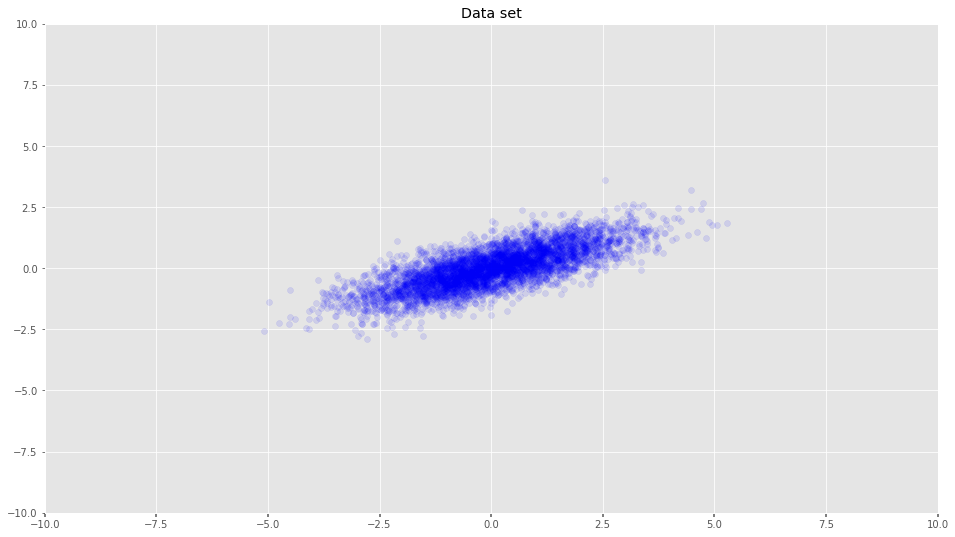

In [63]:
actual_w, actual_z, x_train = model.sample()
print("Principal axes:")
print(actual_w)
fig, ax = plt.subplots(1, figsize=(16,9))
ax.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
ax.axis([-10, 10, -10, 10])
ax.set_title("Data set")

#### Maximum a Posteriori Inference
We first search for the point estimate of latent variables that maximizes the posterior probability density. This is known as maximum a posteriori (MAP) inference, and is done by calculating the values of $W$ and $Z$ that maximise the posterior density $p(W,Z|X)$.

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[2.6820145],
       [1.2405101]], dtype=float32)>


(-20.0, 20.0, -20.0, 20.0)

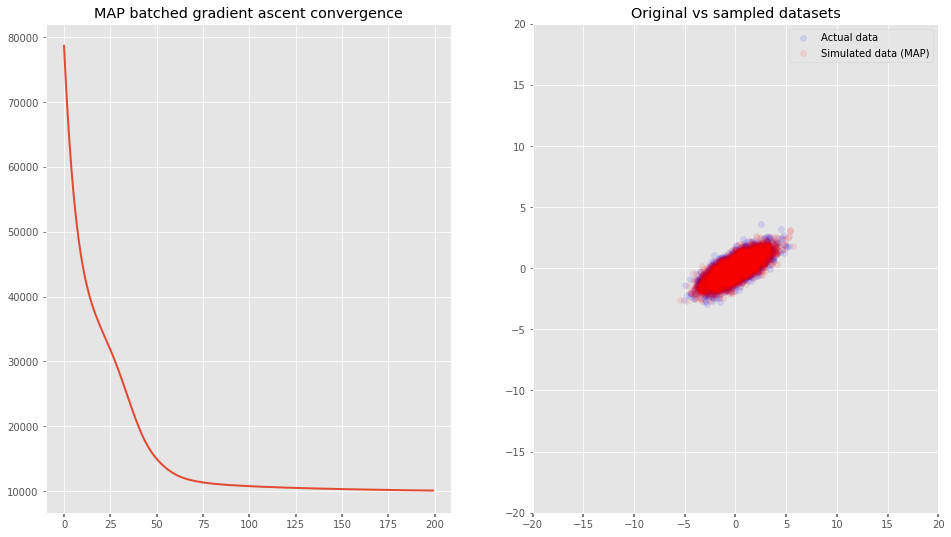

In [64]:
w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, z),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

# We can also use the model to sample data for the inferred values for W and , Z
# and compare to the actual dataset we conditioned on.

print("MAP-estimated axes:")
print(w)
_, _, x_generated = model.sample(value=(w, z, None))
fig, ax = plt.subplots(1,2, figsize=(16,9))
ax[0].set_title("MAP batched gradient ascent convergence")
ax[0].plot(losses)
ax[1].set_title("Original vs sampled datasets")
ax[1].scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
ax[1].scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
ax[1].legend()
ax[1].axis([-20, 20, -20, 20])

In [65]:
_, _, x_generated = model.sample(value=(w, z, None))
print(f"{model.log_prob(value=(w,z,x_generated)):.5f}")

-12526.59668


#### Variational Inference
MAP can be used to find the mode (or one of the modes) of the posterior distribution, but does not provide any other insights about it. We next use variational inference, where the posterior distribtion $p(W,Z|X)$ is approximated using a variational distribution $q(W,Z)$ parametrised by $\lambda$. The aim is to find the variational parameters $\lambda$ that minimize the KL divergence between $q$ and the posterior: $KL\left( q(W,Z) || p(W,Z|X) \right)$ , or equivalently, that maximize the evidence lower bound $\mathbb{E}_{q(W,Z;\lambda)} \left[ log(p(W,Z|X))-log(q(W,Z;\lambda))\right]$

In [66]:
qw_mean = tf.Variable(tf.random.normal([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus()) #Bijector which computes Y = g(X) = Log[1 + exp(X)]
def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

In [70]:
#print(surrogate_posterior)
#print("=================")
#print(surrogate_posterior.parameter_properties())
#print(tfp.vi.fit_surrogate_posterior.__doc__)
surrogate_posterior.__dict__

{'_parameters': {'name': None,
  'experimental_use_kahan_sum': False,
  'validate_args': False,
  'use_vectorized_map': True,
  'batch_ndims': 0,
  'sample_dtype': None,
  'model': <function __main__.factored_normal_variational_model()>,
  '__class__': tensorflow_probability.python.distributions.joint_distribution_auto_batched.JointDistributionCoroutineAutoBatched},
 '_batch_ndims': 0,
 '_experimental_use_kahan_sum': False,
 '_use_vectorized_map': True,
 '_model_coroutine': <function __main__.factored_normal_variational_model()>,
 '_sample_dtype': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_single_sample_distributions', ref=DictWrapper({139830383774520: ListWrapper([<tfp.distributions.Normal 'monte_carlo_variational_loss_JointDistributionCoroutineAutoBatched_sample_qw' batch_shape=[2, 1] event_shape=[] dtype=float32>, <tfp.distributions.Normal 'monte_carlo_variational_loss_JointDistributionCoroutineAutoBatched_sample

#### Notes on variational inference in tensorflow
[From the documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/vi/fit_surrogate_posterior):
Parameters are: tfp.vi.fit_surrogate_posterior(
* target_log_prob_fn
* surrogate_posterior
* optimizer
* num_steps
* convergence_criterion
* trace_fn=_trace_loss
* variational_loss_fn=_reparameterized_elbo
* sample_size=1,
* trainable_variables=None
* seed=None
* name='fit_surrogate_posterior'
)

The default behavior constructs and minimizes the negative variational evidence lower bound (ELBO), given by

* q_samples = surrogate_posterior.sample(num_draws)
* elbo_loss = -tf.reduce_mean(
  target_log_prob_fn(q_samples) - surrogate_posterior.log_prob(q_samples))

The concept of variational inference is to replace the actual log prob. Sampling from $q$ to evaluate the average difference in log_prob is actually equivalent to compute the exepectation E_q over q, that can be shown pretty easily with empirical distribution concept presented in the KL divergence paragraph earlier.

In the current context, the variational parameters are qw_mean, qz_mean, qw_stddv, qz_stddv

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.3028247],
       [-1.5429846]], dtype=float32)>
Standard Deviation:
<TransformedVariable: dtype=float32, shape=[2, 1], fn="softplus", numpy=
array([[0.00784554],
       [0.01004636]], dtype=float32)>


(-20.0, 20.0, -20.0, 20.0)

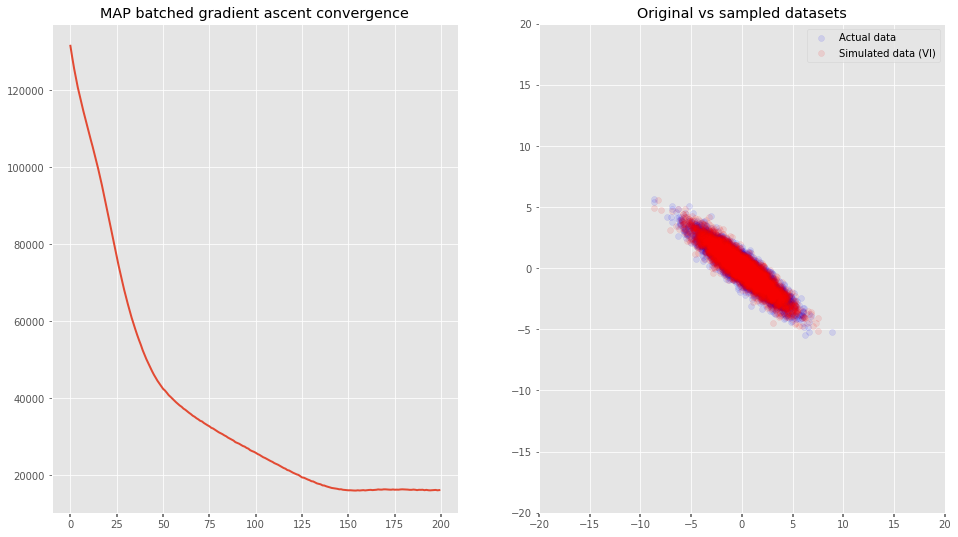

In [18]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

# Now sample from the result. We can actually sample from parameter space itself (\lambda)
# not only get the maximum a posteriori like in the previous example
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

fig, ax = plt.subplots(1,2, figsize=(16,9))
ax[0].set_title("MAP batched gradient ascent convergence")
ax[0].plot(losses)
ax[1].set_title("Original vs sampled datasets")
ax[1].scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
ax[1].scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
ax[1].legend()
ax[1].axis([-20, 20, -20, 20])

### Basic example of variational inference with VAE

The example here comes from the excellent book from Aurelien Geron "Hands on Machine learning with scikit learn and tensorflow", for which there is a nice set of python tutorials there: https://github.com/ageron/handson-ml2

The book cites an (interesting tutorial by Carl Doersch)[https://arxiv.org/abs/1606.05908]

Let's give a bit more informations about this example to replace it within the context of variational inference.

### What is the rationale behind latent loss

Lets consider our posterior $p(z|x)$ which is the probability of latent vector $z$ given a sample image $x$. The simple variational encoder designed here is designed to provide an expression for this posterior:

\begin{align*}
  p(z|x) &= \mathtt{\sim} \mathcal{N} (\mu_x, \sigma_{x}^{2}) \\
  &= \mathtt{\sim} \mathcal{N} (f_{\mu}(x), f_{\sigma^{2}}(x) \\
\end{align*}

Where $f_{\mu}(x)$ and $f_{\sigma^{2}}$ are just few layers of dense nn with selu activation and a last affine layer (dense without activation).

Ok, now, we must recall that $f_{\mu}(x)$ and $f_{\sigma^{2}}$ are useful if they can learn commonalities between many samples drawn from $X$. So that, for each $x$, they can generate a distribution, with the following properties:
* 1: simple enough so that we can easily sample from it (this actually a built in constraint given by the choice of the normal distribution)
* 2: have a high density for areas in z that correspond to vectors that can be used by the decoder to reconstruct real samples

Lets quickly recall the expression of Kullback Leibler between posterior and desired variational distribution:
\begin{align*}
    D_{KL}(q\|p) &= \mathbb{E}_q \left[ log \left( \frac{q(z)}{p(z|x)} \right) \right] \\
    &= \mathbb{E}_q \left[ log \left( q(z) \right) \right] - \mathbb{E}_q \left[ log \left( p(z|x) \right) \right] \\
        &= \mathbb{E}_q \left[ log \left( q(z) \right) \right] - \mathbb{E}_q \left[ log \left( p(z,x) \right) \right] + \mathbb{E}_q \left[ log \left( p(x)\right) \right] \\
    &= -\left( \underbrace{\mathbb{E}_q \left[ log \left( p(x,z) \right) \right] - \mathbb{E}_q \left[ log \left( q(z) \right) \right]}_{\text{= ELBO}}\right) + log \left( p(x)\right)\\
\end{align*}

Now let see how the ELBO translate for two univariate normal distributions:

\begin{align*}
  ELBO &= \mathbb{E}_q \left[ log \left( p(x) \right) \right] - \mathbb{E}_q \left[ log \left( q(x) \right) \right] \\
  &= \mathbb{E}_q \left[ log \left( \frac{1}{\sigma_p\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu_p}{\sigma_p }\right)^{2}} \right) \right] - \mathbb{E}_q \left[ log \left( \frac{1}{\sigma_q\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^{2}} \right) \right]\\
  &= \mathbb{E}_q \left[ -log(\sigma_p) -log(\sqrt{2\pi}) -\frac{1}{2} \left(\frac{x-\mu_p}{\sigma_p }\right)^{2} \right] - \mathbb{E}_q \left[-log(\sigma_q) -log(\sqrt{2\pi}) -\frac{1}{2} \left(\frac{x-\mu_q}{\sigma_q }\right)^{2}\right]\\
\end{align*}

Proper distributions like normal always integrates to one, so we can factor out constants:

\begin{align*}
  ELBO &= -log(\sigma_p)-log(\sqrt{2\pi}) + log(\sigma_q) + log(\sqrt{2\pi})
          -\frac{1}{2} \mathbb{E}_q\left[ \left(\frac{x-\mu_p}{\sigma_p }\right)^{2} \right]
          +\frac{1}{2} \mathbb{E}_q \left[ \left(\frac{x-\mu_q}{\sigma_q }\right)^{2}\right]\\
\end{align*}

In the last expression, it can be easily spotted that $\mathbb{E}_q \left[ \left(\frac{x-\mu_q}{\sigma_q }\right)^{2}\right] = 1$ as it is a well known property of normal distributions.

Now we have

\begin{align*}
  ELBO &= log \left( \frac{\sigma_q}{\sigma_p} \right) + \frac{1}{2} -
          \frac{1}{2\sigma_p^2} \mathbb{E}_q \left[(x-\mu_p)^{2} \right] \\
\end{align*}

where

\begin{align*}
  (x-\mu_p)^{2} &= (x-\mu_q+\mu_q-\mu_p)^{2} \\
  &= (x-\mu_q)^{2} +(\mu_q-\mu_p)^{2} + 2 (x-\mu_q)(\mu_q-\mu_p) \\
\end{align*}

We can plug that expression back in the expectation over $q$ in the original ELBO derivation:

\begin{align*}
ELBO &= log \left( \frac{\sigma_q}{\sigma_p} \right) + \frac{1}{2} -
        \frac{1}{2\sigma_p^2} \mathbb{E}_q \left[(x-\mu_p)^{2} \right] \\
     &= \frac{\sigma_q}{\sigma_p} + \frac{1}{2} -
        \frac{1}{2\sigma_p^2} \mathbb{E}_q \left[(x-\mu_q)^{2}
                                                 +(\mu_q-\mu_p)^{2}
                                                 + 2 (x-\mu_q)(\mu_q-\mu_p) \right] \\
     &= log \left( \frac{\sigma_q}{\sigma_p} \right) + \frac{1}{2} -
        \frac{1}{2\sigma_p^2} \left( \mathbb{E}_q \left[(x-\mu_q)^{2} \right]+
                                     \mathbb{E}_q \left[(\mu_q-\mu_p)^{2} \right]+
                                     2(\mu_q-\mu_p) \mathbb{E}_q \left[ (x-\mu_q)\right] \right) \\
     &= log \left( \frac{\sigma_q}{\sigma_p} \right) + \frac{1}{2} -
        \frac{1}{2\sigma_p^2} \left( \sigma_q^2 +
                                     (\mu_q-\mu_p)^{2} \right) \\
     &= log \left( \frac{\sigma_q}{\sigma_p} \right) + \frac{1}{2} -
        \frac{\sigma_q^2+(\mu_q-\mu_p)^{2}}{2\sigma_p^2} \\
\end{align*}

The term $2(\mu_q-\mu_p) \mathbb{E}_q \left[(x-\mu_q)\right]$ simply vanishes because of symmetry of the normal distribution around $\mu_q$
And we used the normal property to compute $\mathbb{E}_q \left[(x-\mu_q)^{2}\right]=\sigma_q^2$

As mentionned earlier $log \left( p(x)\right)$ is constant across the learning process, so there is no need to take it into account for the upcoming optimization steps. 

Basically, what we want is to minimize the KL divergence between  between
\begin{align*}
  -\text{ELBO} &= -\frac{1}{2} \left(
                    1
                    + log \left( \frac{\sigma_q}{\sigma_p} \right)
                    - \frac{\sigma_q^2+(\mu_q-\mu_p)^{2}}{\sigma_p^2} \right) \\
\end{align*}

As, by design, this VAE choose to 

\begin{align*}
  \mathcal{L} &= - \frac{1}{2} \sum_{i=0}^{K-1} 1 + log(\sigma_{i}^{2}) - \sigma_{i}^{2} - \mu_{i}^{2} \\
\end{align*}


In [6]:
# Few utility functions
K = keras.backend

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# We will be working with fashion mnist dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

# Dimensionality of the latent space
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

# Last layer to compute f_{\mu}, and f_{log(\sigma^2)}
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

# Sampling operator: N(0,1) * exp(log(\sigma^2)/2) + \mu give the actual output of the encoder
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Now define the decoder, this one is not "variational". There is no concept of randomness here
# Some implementations of GANs, like StyleGans
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# Define placeholders for overall model
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# Latent loss is where the variational aspect takes place.
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# Main loss is usual cross entropy (image values are between 0 and 1)
# we could have used mse for reconstruction to test
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 9ms/step - loss: 0.4437 - rounded_accuracy: 0.8155 - val_loss: 0.3526 - val_rounded_accuracy: 0.8906
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3462 - rounded_accuracy: 0.8953 - val_loss: 0.3412 - val_rounded_accuracy: 0.9036
Epoch 3/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3343 - rounded_accuracy: 0.9039 - val_loss: 0.3335 - val_rounded_accuracy: 0.9052
Epoch 4/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3291 - rounded_accuracy: 0.9082 - val_loss: 0.3318 - val_rounded_accuracy: 0.9101
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3252 - rounded_accuracy: 0.9116 - val_loss: 0.3254 - val_rounded_accuracy: 0.9132
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3241 - rounded_accuracy: 0.9131 - val_loss: 0.3250 - val_rounded_accuracy: 0.9100
Epoch 7/25
430/430 [==============================] 

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(variational_ae)
plt.show()

#### VAE and dimensionality reduction

Lets take a look at how to perform dimensionality reduction with VAE:

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Sampling from VAEs

Lets take a look at how to perform sampling with VAE:

In [11]:
# Utility function to show grid of images
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

## Transforming distributions with bijectors

### Introduction

The fundamental equation we need here, is known for a very long time, and relates to change of variable, initially used to integrate quantities in physics.
Given an invertible function:$f:\underset{Z}{z} \mapsto \underset{X}{x}$ and a distribution $p_{\theta}(z), \; z \in Z$, the change of variable forumla reads

\begin{align*}
  p_{\theta}'(x) &= p_{\theta}\left( f^{-1}(x) \right) |det \left( J_{f^{-1}} \right)| \\
  p_{\theta}'(x) &= p_{\theta}\left( f^{-1}(x) \right) \frac{1}{|det \left( J_{f}\right)|} \\
\end{align*}

Where $|det \left( J_{f}\right)|$ is the absolute value of the determinant of the Jacobian of $f$.
In order for this formula to be applicable, we directly see that $f$ needs to be invertible (it is a bijector) and the determinant of its jacobian (respectively the jacobian of its inverse) needs to be defined everywhere.

One would be tempted to say that it needs to be differentiable everywhere, so that the union of those 2 properties for a function forms a diffeomorphism. However, the set of invertible function that have the determinant of their jacobian defined everywhere, and the set of invertible functions that have their full jacobian defined everywhere (ie are differentiable) is different, we can build example of the former with a clever trick we will see hereafter. This is why Normalizing flows layers are ofter called bijectors in normalizing flows litterature.

Normalizing flows layers properties are closed under composition, which means that composing NF layers produces a NF with the same nice properties, while allowing a better expressivity.

### Quick recall, what is a Jacobian ?

We first recall that, for a function $f:\underset{\mathbb{R}^n}{x} \mapsto \underset{\mathbb{R}^n}{f(x)}$, we can derive the matrix of partial derivative, called the jacobian matrix:

\begin{align*}
  J=\begin{pmatrix}
    \frac{\partial f_0}{\partial x_0} & \frac{\partial f_0}{\partial x_1} & \dots & \frac{\partial f_0}{\partial x_{n-1}}\\
    \frac{\partial f_1}{\partial x_0} & \frac{\partial f_1}{\partial x_1} & \dots & \frac{\partial f_1}{\partial x_{n-1}}\\
  \vdots & \vdots & \vdots & \vdots \\
  \frac{\partial f_{n-1}}{\partial x_0} & \frac{\partial f_{n-1}}{\partial x_1} & \dots & \frac{\partial f_{n-1}}{\partial x_{n-1}}
\end{pmatrix}
\end{align*}

### Chain rule for transformation composition

As seen in the DifferentiatingPerceptron notebook, for complex functions, that are applied each after another, like in most deep learning models (excepted here we are only interested in bijective layers), the chain rule applies, and we have, for an initial distribution:
\begin{align*}
  p_{\theta}(z), \; z \in Z
\end{align*}
And a chain of bijective transforms:
\begin{align*}
  x = f_{\theta}(z) = f_{K-1} \circ f_{K-2} \circ \dots \circ f_{1} \circ f_{0}(z)
\end{align*}
The following holds
\begin{align*}
  p_{\theta}'(x) &= p_{\theta}(z) \prod_{i=0}^{K-1}\frac{1}{|det \left( J_{f_i}\right)|} \\
  p_{\theta}'(x) &= p_{\theta}\left( f_{\theta}^{-1}(x) \right) \frac{1}{|det \left( J_{f_{\theta}}\right)|} \\
\end{align*}

Throughout this notebook, we will mostly use $z$ as a placeholder for the latent variable, $f_{\theta}$ as the bijective transformation, parametrized by $\theta$ that can generated and observed variable $x$, the later will often have larger dimension, to express images or time series.

Now, let's assume we would like to compute the (log) likelihood of a given sample $x$:
\begin{align*}
  log (p_{\theta}'(x)) &= log(p_{\theta}(z)) - \sum_{i=0}^{K-1} log \left( |det \left( J_{f_i}\right)| \right) \\
\end{align*}

Depending on the invertible set of transform you use, given you have acces to automatic differentiation, this expression of likelihood can be use within an optimization objective in order to learn useful representations encoded by $f_{\theta}$, given a set of training examples $\{x_0, x_1, \dots x_{n-1} \in X\}$.

### VAE vs GANs vs NF

As we have seen previously, VAE use variational inference, which is optimizing for the ELBO, which is a surrogate for the posterior distribution of latent variables given a sample for the encoder. We don't get the exact posterior.

In GAN, there is basically no encoder, hence it is impossible to compute likelihood of latent variable given a sample. We can only train the generator/discriminator in a min/max fashion, with the usual risks of mode collapse, or infinite oscillations.

From a theoretical point of view, NF has very interesting properties, as it allows exact likelihood evaluation, and potentially optimization during training by $log(p_{\theta}(z)) - \sum_{i=0}^{K-1} log \left( |det \left( J_{f_i}\right)| \right)$
Exact posterior inference for a given $x$ throught the invertible transform $z=f_{\theta}^{-1}(x)$

Unfortunately, all those theoretical advantages will come with complex numerical challenges, such as finding transformations with tractable and numerically stable Jacobian determinant computations. One often tries to find transformations which Jacobian is diagonal or triangular.

## Normalizing flows: example of bijective systems in DL

### Intrinsic limitations of linear transform

Although we know some tricks to compute inverse and determinants of the jacobian for some types of linear transform, including  convolutions, full rank matrices, etc... linear transform as well are closed under composition, which means that for a set of standard distribution, an arbitrary composition of linear transformation would only allow to generate a new set of standard distribution with changes in the means and variances, which in the end, is not really adding a lot of expressivity.

This is the reason why some substancial efforts have been invested in the research of Normalixzing Flow layers that would provide better expressivity.


### Non linear independent components estimation (NICE)

#### The triangular trick
In the paper Non Linear independent components estimation (see [here](https://arxiv.org/abs/1410.8516) or [here](https://paperswithcode.com/method/nice) ) the authors use the concept of coupling layer.

Coupling layer subsets input, let say for instance into 2 subsets (by simply projecting onto two complementary and trivial supports) and then apply identity on one part of this subset, and apply more complex transformation $g$ that use both subsets for the second output, with an intermediate transformation $m$ over thr first subset:

* inputs: $z_{0:d-1}$ and $z_{d:D-1}$
* output 1 is identity: $x_{0:d-1} = z_{0:d-1}$
* output 2: $x_{d:D-1} = g(z_{d:D-1},m(z_{0:d-1}))$

If you look carefully, you can see that the Jacobian of said transformation will look like this:

\begin{align*}
  J_f &= \begin{pmatrix}
    \frac{\partial Id_{0:d-1}}{\partial z_{0:d-1}} & \frac{\partial Id_{0:d-1}}{z_{d:D-1}} \\
    \frac{\partial g\left(z_{d:D-1},m(z_{0:d-1}\right)}{\partial z_{0:d-1}} & \frac{ \partial g\left(z_{d:D-1},m(z_{0:d-1}\right)}{\partial z_{d:D-1}} \\
\end{pmatrix} \\
&= \begin{pmatrix}
    Id_{0:d-1} & 0\\
    \frac{\partial g\left(z_{d:D-1},m(z_{0:d-1}\right)}{\partial z_{0:d-1}} & \frac{ \partial g\left(z_{d:D-1},m(z_{0:d-1}\right)}{\partial z_{d:D-1}} \\
\end{pmatrix}
\end{align*}

##### Solving the invertibility
The problem of having a triangular jacobian then amounts to having the lower right part of previous expression triangular. If we analyse the invertibility requirement, we can see that, Identity being trivially invertible, we should concentrate on $g$.
Now $g$ mainly needs to be invertible with regard to its first argument, given the second, because second argument $m(z_{0:d-1})$ can always be fully inverted thanks to the identity in the other output. In the NICE paper, $g$ is set to be a simple addition, and all the complexity (DNN) is used in the $m$ function.

##### Solving the determinant of the jacobian
Besides invertibility, you can also see that the lower right term: $\frac{ \partial g\left(z_{d:D-1},m(z_{0:d-1}\right)}{\partial z_{d:D-1}}$ does not involves deriving $m$ with respect to its parameters $z_{0:d-1}$, but with respect to $z_{d:D-1}$. So basically,  the triangular trick allows you to embed arbitrarily complex and nonlinear, non invertible transform like neural network inside of $m$.

#### Beyond lower/upper simple split with permutation
Applied as is, the former triangular trick allowing for better expressivity through $m$ always apply to first half of the input space $z_{0:d-1}$. a simple trick to overcome this problem is to apply either random or structured permuation (permutation jacobian have either a determinant of +1 or -1) before using coupling layers.

#### Beyond additive coupling with scaling matrix
Additive coupling layers like $g$ given as an example, are very limited in the sense that their unit gaussian forbids local expansion or contractions, which drastically reduces the expressivity of such functions.

To start with, given one of our target which is to keep latent space $Z$ distribution to be as simple as possible (gaussian ?) while having the power to be matched with complex multimodal distribution of sample space $X$, we need those complex transformation.
Also in the framework of generative network, we would like high density regions from sample space $X$ to expand to large regions of the latent space $Z$ for expressivity.

The authors show that, this problem can somehow be circumvented by using a diagonal feature scaling matrix $S$ before applying $f$ transformations when decoding from the latent space.
The log likelihood for a given decoding then reads:

\begin{align*}
  log (p_{\theta}'(x)) &= \sum_{i=0}^{D-1} log(p_{\theta}(f^{-1}(x)_i) - log \left( |S_{ii}| \right) \\
\end{align*}

### Beyond dimensionality constraints of bijectors: Real NVP

The problem with bijectors, is that by design, input and output dimensionality should be equal. Although in general, latent space in generative models are expected to be smaller in dimension. This is the problem the authors of [Real NVP](https://arxiv.org/abs/1605.08803) see explanation with code [here](https://paperswithcode.com/method/realnvp) or [here](https://keras.io/examples/generative/real_nvp) tried to address.

In this work, authors tried to use a multiscal approach for images, where each set of latent variable was operating on a different resolution from the sample space.

Mathematically, the idea is to re-use the concept of coupling layers, recursively, but make the coupling transformation $m$ completely independant of the first part of the vector, by for instance, using a subsampling of the image at different scales.

### Recursive coupling flows
This idea was introduced in a 2020 paper: 
[HINT: Hierarchical Invertible Neural Transport for Density Estimation and Bayesian Inference
](https://arxiv.org/abs/1905.10687)
![title](data/HINT_Jacobian.png)
courtesy: Marcus A. Brubaker from [here](https://www.youtube.com/watch?v=u3vVyFVU_lI)

### Masked autoencoder and masked autoregressive flow for density estimation

Mostly refers to [MADE Masked Autoencoder for Distribution Estimation](https://arxiv.org/abs/1502.03509) and [Masked Autoregressive Flow for Density Estimation](https://arxiv.org/abs/1705.07057) see author interview [here](https://www.youtube.com/watch?v=315xKcYX-1w)

The initial idea of autoregressive models is to take the likelihood of an output sequence as a product of conditional probability of each element upon its predecessor:

\begin{align*}
  p_{\theta}(x_0, x_1, \dots x_{n-1}) &= \prod_{i=0}^{n-1} p_{\theta}(x_i|x_{0:i})\\
\end{align*}

Let see how this idea has been used in the context of autoregressive flows

#### Gaussian marginals
The first important aspect of autoregressive flows is that each variable is conditionally modeled upon its predecessor as a gaussian, where mean and variance are a function of the actual values of the known predecessor:

\begin{align*}
  p(x_i|x_{0:i}) &= \mathcal{N}(x_i | f_{\mu}(x_{0:i}), f_{\sigma}(x_{0:i})^2)\\
\end{align*}

#### Reparametrization trick

For each element in the sequence, one can write its distribution as
\begin{align*}
  x_i = \mu_i + z_i \times \sigma_i^2\\
\end{align*}
with
\begin{align*}
  z_i \mathtt{\sim} \mathcal{N}(0,1) \quad \text{and} \quad\mu_i = f_{\mu}(x_{0:i}) \quad \text{and} \quad \sigma_i^2 = f_{\sigma^2}(x_{0:i})\\
\end{align*}

#### Properties of autoregressive flows for sampling/density estimation
You can see that the simple chain rule used to build conditional probability model parameters will translate into a triangular jacobian. given that $f_{\mu}$ and $f_{\sigma^2}$ are differentiable. The reparametrization trick however, as it will be used for each and every single dependant variable will make the sampling task for the model a bit more cumbersome, as one will have to perform as many normal sampling + computation of next variable parameters as there are variables. And those computation are note independent, hence cannot be parallelized efficiently.

However, providing density for a given sample $x$ by computing $f^{-1}$ should be pretty easy to parallelize (TBD) 

#### Inverse autoregressive flows

The idea here is to inverse the direction of the flow to make one task (i.e sampling) much faster than the other (computing f^{-1} for density estimation)

#### See also

See also inverse regressive flows see [improved variational inference with inverse autoregressive flow](https://arxiv.org/abs/1606.04934) and [
Parallel WaveNet: Fast High-Fidelity Speech Synthesis](https://arxiv.org/abs/1711.10433)

### Normalizing flows and VAE

Up to now, we have mostly seen how to derive likelihood of samples from a distribution of latent variable (hoping to back propagate the error in likelihood to learn something useful).

We might want to parametrize the approximate posterior $p(x|z)$ in a VAE with a flow to form richer distributions. This is very interesting, as usually in VAE you are restricted to a simple multidimensional gaussian distribution in the latent space, although you could leverage normalizing flow to turn this gaussian encoder output into a more complex distribution before decoding.

![title](data/vae_normalizing_flow.png)
![title](data/vae_normalizing_flow2.png)
courtesy: Ari Seff from [here](https://www.youtube.com/watch?v=i7LjDvsLWCg)

This is the idea of Rezende & all in [Variational Inference with Normalizing Flows](https://arxiv.org/abs/1505.05770)

### Neural ODE and continuous-time normalizing flows
What if, instead of applying discret set of transform one after the other in layers in order to, expand or contract probability densities towards a simple distribution, we could perform this process smoothly.

This is the idea behind the [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) paper and its application to normalizing flows in [FFJORD: Free-form Continuous Dynamics for Scalable Reversible Generative Models](https://arxiv.org/abs/1810.01367).

In the FFJORD paper, auther propose to use the solution to the initial value problem as a normalizing flow:
\begin{align*}
  f(x) = y_0 + \int_{0}^{1} h(t, y_t) dt \quad \text{with $y_0=x$}
\end{align*}
where:
* $f(x)$ is the normalizing flow
* $h(t, y_t)$ is the partial differential equation, whose parameters we are going to learn
* $t$, the time variable is used to model the normalizing flow as a smooth transformation integrated over a time range from 0 (now) to 1 (an arbitrary point in the future)

![title](data/nfpde.png)
courtesy: Marcus A. Brubaker from [here](https://www.youtube.com/watch?v=u3vVyFVU_lI)


The interesting property is that the inverse is actually quite nice:
\begin{align*}
  f^{-1}(z) = y_1 + \int_{1}^{0} h(t, y_t) dt \quad \text{with $y_1=z$}
\end{align*}

However, the flow normalization expression is a bit different in that case:
\begin{align*}
  log p_X(x) = log p_Z(f(x)) \int_{1}^{0} Tr \left( \frac{\partial h(t, y_t)}{\partial y} dt \right)
\end{align*}

FFJORD paper ultimately introduce a mathematical tool called Hutchinson trace estimator that simplifies this expression to make it tractable.

## Normalizing flows: main references
Here are a few very important references we might refere to

### Generic normalizing flow references

Basic introduction with a great youtube video from Ari Seff:
https://www.youtube.com/watch?v=i7LjDvsLWCg

Video recording of ECCV2020 Introduction session to Normalizing Flows by Marcus A. Brubaker
https://www.youtube.com/watch?v=u3vVyFVU_lI

In [2]:
from IPython.display import IFrame

Lets start with the amazing work of Mahdi Karami. The document is a PhD thesis dedicated to the study of tools for variational inference, normalizing flows, analysis and design of operator with tractable inverse jacobian computation, with additional numerical and convex optimization tools. It also contains applications to latent space representations of complex distributions met in signal/image processing, and much more:

In [1]:
#IFrame("doc/NormalizingFlows/Karami_Mahdi_202008_PhD.pdf", width=1200, height=800)

Then lets move on to a very interesting review paper: Normalizing Flows: An Introduction and Review of Current Methods by Ivan Kobyzev, Simon J.D. Prince, and Marcus A. Brubaker.

In [2]:
#IFrame("doc/NormalizingFlows/1908.09257.pdf", width=1200, height=800)

Another reference paper, that exposes a lot of important properties of Normalizing flows, and design of methods to leverage them in machine learning / representation learning: Normalizing Flows for Probabilistic Modeling and Inference by George Papamakarios, Eric Nalisnick, Danilo Jimenez Rezende, Shakir Mohamed, Balaji Lakshminarayanan

In [3]:
#IFrame("doc/NormalizingFlows/1912.02762.pdf", width=1200, height=800)

### Normalizing flows for images

Then a paper more targeted to application: Same Same But DifferNet: Semi-Supervised Defect Detection with Normalizing Flows by Marco Rudolph, Bastian Wandt and Bodo Rosenhahn:

In [5]:
#IFrame("doc/NormalizingFlows/2008.12577.pdf", width=1200, height=800)

Paper introducing a solution to manage multi layer images: Glow: Generative Flow with Invertible 1x1 Convolutions by Diederik P. Kingma and Prafulla Dhariwal, that managed to generate realistic looking images by sampling their model.

In [6]:
#IFrame("doc/NormalizingFlows/1807.03039.pdf", width=1200, height=800)

A paper targeting the issue with digital value quantization at risk of generating singularities in distribution estimation, by adding quantization noise: Flow++: Improving Flow-Based Generative Models with Variational Dequantization and Architecture Design by Jonathan Ho, Xi Chen, Aravind Srinivas and Yan Duan, Pieter Abbeel

In [ ]:
#IFrame("doc/NormalizingFlows/1902.00275.pdf", width=1200, height=800)